# ACSE4 2020 Machine Learning Mini-project ------- X-Ray Classification 
<hr>

## Group : MaxPool


# Getting Started

You will need to register for a Google Account (Make a throwaway account if you do not want google to have your data).  

Register on the Kaggle Platform (required for Mini-Project): [Link](https://www.kaggle.com)


## Prepare data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
import torch
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [4]:
import os
os.chdir("/content/gdrive/MyDrive")

# upload kaggle.json 
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle (15).json


In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

In [5]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [6]:
!kaggle competitions download -c acse4-ml-2020 -p /content/gdrive/MyDrive/acse4

acse4-ml-2020.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#check if we have acse4-ml-2020.zip
import os
os.chdir("/content/gdrive/MyDrive/acse4")
!ls

In [ ]:
!unzip acse4-ml-2020.zip -d "/content/sample_data/"

In [5]:
# change path to sample_data
os.chdir("/content/sample_data")   

## connect to wandb.ai

In [6]:
%%capture
!pip install wandb -qqq
import wandb

In [7]:
!wandb login

wandb: Currently logged in as: ewan (use `wandb login --relogin` to force relogin)


## Library

In [ ]:
!pip install pycm livelossplot
%pylab inline

In [10]:
import random
import re
import progressbar
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
import numpy as np
import torch

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, TensorDataset, Dataset
from torch.utils.data import random_split, WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F

from livelossplot import PlotLosses
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

import torchvision.transforms as tt
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage
from torchvision.datasets import ImageFolder 
import cv2


from glob import glob


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

Get the path for our training data and test data, also we create one more "test" folder inside the "./test" folder, which is useful for the implmentation of the `ImageFolder` function.

In [11]:
# define the different folder pathes
data_directory = os.listdir('./xray-data/')
data_dir = "./xray-data/xray-data/"
train_dir = os.path.join(data_dir, "train/")
test_dir = os.path.join(data_dir, "test/")

In [16]:
# make file test under the test folder
!cd ./xray-data/xray-data/test && mkdir test

In [17]:
!mv ./xray-data/xray-data/test/* ./xray-data/xray-data/test/test

mv: cannot move './xray-data/xray-data/test/test' to a subdirectory of itself, './xray-data/xray-data/test/test/test'


# Preprocessing data:

Before we continue, we shold load all the image files, so we will use ImageFolder to complete this task.

Here we crop the image into 224*224. The reasons are as follow:

1. Large image take up more memory.

2. Entering a smaller size image will not affect our learning of lung features.(check by **visualize the image** part)

In [12]:
# Generate Datasets from `./train` and `./test` folder, quite handy to use `ImageFolder`, 
# we also perform a centercrop to reshape the picture to 224 * 224 for a initial data augmentation:
# create the augmentation for initialize the training and testing data
init_transform = tt.Compose([
    tt.CenterCrop((224, 224)),   # crop the pictures into 224*224
])

In [13]:
# get the data from train folder and test folder
train_data = ImageFolder(train_dir, init_transform)
test_data  = ImageFolder(test_dir, init_transform)

## Prepare the Dataset

### Calculate the means and standard deviation

Means and std have been calculated in other .ipynb files of this project, so they are used directly here.

In [16]:
means = [0.55006141, 0.55006141, 0.55006141]
stds = [0.17962446, 0.17962446, 0.17962446]

### Change Labels (Dataset `MyDataset`)

Because the initial corresponding results are wrong at this task, We wrote a custom dataset `MyDataset` to swap the labels generated by`imageFolder` (2 <-> 3)

In [17]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]

        if self.transform:
            x = self.transform(x)
            
        if y == 2:
           return x, 3
        elif y == 3:
           return x, 2
        else:
           return x, y
        
    def __len__(self):
        return len(self.subset)

### Random split the train data

Becaue number of the images in train folder is too large, we can randomly select images in train folder. By calling `random_split` function to complete this task

In [18]:
# this range is from 0 to 1. It defines the range of all training data used for training
# if you want full, just enter 1

split_ratio = 0.05

In [83]:
seed = 42
set_seed(seed);

train_splite_num = int(len(train_data) * split_ratio)
train_ignore_num = len(train_data) - train_splite_num

train_splite, train_ignore = random_split(train_data, [train_splite_num, train_ignore_num])

test_splite_num = int(len(train_ignore) * 0.1)
data_ignore_num = len(train_ignore) - test_splite_num
test_subDs, data_ignore = random_split(train_ignore, [test_splite_num, data_ignore_num])

validation_num = int(len(train_splite)*0.1)
train_num = len(train_splite) - validation_num
train_subDs, validation_subDs = random_split(train_splite, [train_num, validation_num])

train_dataset_size = len(train_data)

print('Number of training:', len(train_subDs))
print('Number of validation:', len(validation_subDs))
print('Number of testing:', len(test_subDs))

Number of training: 909
Number of validation: 101
Number of testing: 1920


### Define transformations

In [20]:
# define the augmentation for initialize the training set and validation set
train_transform = tt.Compose([
    # tt.ToPILImage(), 
    tt.RandomHorizontalFlip(0.5),
    tt.CenterCrop((224, 224)), # resize the pictures
    tt.ToTensor(),
    tt.Normalize(means, stds)
])

val_transform = tt.Compose([
    # tt.ToPILImage(), 
    tt.CenterCrop((224, 224)),
    tt.ToTensor(),
    tt.Normalize(means, stds)
])


In [84]:
train_subDs = MyDataset(train_subDs, train_transform)
validation_subDs = MyDataset(validation_subDs, val_transform)

if split_ratio != 1:
   test_subDs = MyDataset(test_subDs, val_transform)

# Final model

## Train the model

In [24]:
def train(model, optimizer, criterion, data_loader, accuracy_score_type = 'normal'):
  """
  Train the model with provided training data.
  ---
  model: the neutral network
  optimizer: it is used to update the weight parameters
  criterion: it is used to calculate the loss
  data_loader: the training dataloader
  accuracy_score_type: the default is normal, we can choose 'normal' or
             'f1_score' to compute accuracy_score or compute F1_score
  """
  #wandb.watch(model, criterion, log="all", log_freq=10)
  model.train()   # the model is in the training mode so the parameters(weights)to be optimised will be updated
  train_loss, train_accuracy = 0, 0  # initialise loss and accuracy to 0 for training
    
  for X, y in data_loader: # iterate over the mini-batches defined in the data loader
    X, y = X.to(device), y.to(device)   # send data to the device (GPU in our case)
    optimizer.zero_grad()               # resetting optimiser info
    a2 = model(X.view(-1, 3, 224, 224))   # forward pass
    loss = criterion(a2, y)        # compute loss
    loss.backward()              # backpropagation to calculate the gradients
    train_loss += loss*X.size(0)   # add it up for different mini-batches and undo loss normalisation
    y_pred = F.log_softmax(a2, dim=1).max(1)[1]  # get predictions

    if accuracy_score_type == 'normal':
      train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # compute accuracy_score
    elif accuracy_score_type == 'f1_score':
      train_accuracy += f1_score(y.cpu().numpy(), y_pred.detach().cpu().numpy(), average = 'macro') * X.size(0) # compute F1_score
        
    optimizer.step()  # perform a step of gradient descent
    #cnt_progress += X.size(0)
    #bar.update(cnt_progress)
        
  return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)   # here we can average over the whole dataset

# does not need optimiser
def validate(model, criterion, data_loader, accuracy_score_type = 'normal'):
  """
  Test the model with provided validation data.
  ---
  model: the neutral network
  optimizer: it is used to update the weight parameters
  criterion: it is used to calculate the loss
  data_loader: the training dataloader
  accuracy_score_type: the default is normal, we can choose 'normal' or
             'f1_score' to compute accuracy_score or compute F1_score
  """
  model.eval()            # model is set to evaluation mode so no dropout or any other funny stuff here
  validation_loss, validation_accuracy = 0, 0 # initialise loss and accuracy to 0 for training
  for X, y in data_loader:   # iterate over the mini-batches defined in the data loader
      with torch.no_grad():  # deactivates autograd engine
        X, y = X.to(device), y.to(device)   # send data to the device (GPU in our case)
        a2 = model(X.view(-1, 3, 224, 224))   # forward pass
        loss = criterion(a2, y)    # evaluate loss
        validation_loss += loss*X.size(0)    # add it up for different mini-batches and undo loss normalisation
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]   # get predictions
        if accuracy_score_type == 'normal':
          validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # compute accuracy_score
        elif accuracy_score_type == 'f1_score':
          validation_accuracy += f1_score(y.cpu().numpy(), y_pred.detach().cpu().numpy(), average = 'macro') * X.size(0) # compute F1_score
            
        #cnt_progress += X.size(0)
        #bar.update(cnt_progress)
        #wandb.log({"batch validation loss":validation_loss})

  #wandb.log({"validation loss":validation_loss/config.test_batch_size})

  return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset
  
def evaluate_roc_auc_score(model, data_to_test):
    model = model.to(device)
    pred_matrix = np.zeros((len(data_to_test), 4))
    y_true = np.zeros(len(data_to_test))
    cnt_progress = 0
    bar=progressbar.ProgressBar(maxval=len(data_to_test))
    for i in range(len(data_to_test)):
        tensor = data_to_test[i][0].to(device)
        y_true[i] = data_to_test[i][1]
        tensor = tensor.reshape(1,3,224,224)
        out = model(tensor)
        y_pred_prob = F.softmax(out, dim=1)
        pred_matrix[i] = y_pred_prob.detach().cpu().numpy()
        cnt_progress+=1
        bar.update(cnt_progress)
    bar.finish()

    test_accuracy = roc_auc_score(y_true, np.array(pred_matrix), labels = np.array([0,1,2,3]), multi_class='ovr')
            
    return test_accuracy / len(data_to_test)  ## return the multi-class roc_auc_score

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1,3, 224,224))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [100]:
def evaluate(model, data_loader):
    '''
    simply returns all predictions on a given dataset
    ---
    model: the neutral network
    data_loader: the training dataloader
    '''
    model.eval()
    ys, y_preds, y_probs = [], [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1,3, 224,224))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            y_prob = F.softmax(a2, dim=1)
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            y_probs.append(y_prob.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0), np.concatenate(y_probs, 0).T

### Training model with wandb

In [76]:
def train_RESNET18_wandb():
    '''
    Train the model with training dataset and validate dataset and connect with wandb.ai.
    '''
    set_seed(42)

    config_defaults = {
        'epochs': 5,
        'batch_size': 64,
        'learning_rate': 1e-3,
        'optimizer': 'adam',
        'dropout': 0.5,
        'test_batch_size':1000,
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    config = wandb.config

    model =  models.resnet18(pretrained=True).to(device)
    fc_in = model.fc.in_features
    model.fc = nn.Linear(fc_in, 4).to(device)
    
    if config.optimizer == 'sgd':
       optimizer_ = torch.optim.SGD(model.parameters(), lr=config.learning_rate, momentum=config.momentum, weight_decay=config.weight_decay)
    elif config.optimizer == 'adam':
       optimizer_ = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    
    criterion = nn.CrossEntropyLoss()
    
    train_loader = DataLoader(train_subDs, batch_size=config.batch_size, shuffle=True, num_workers=0)  # train_loader
    validation_loader = DataLoader(validation_subDs, batch_size=config.test_batch_size, shuffle=False, num_workers=0) # validation_loader
    
    # Plot
    liveloss = PlotLosses()
    #wandb.watch(model, log="all")
    for epoch in range(config.epochs):
        train_loss, train_acc = train(model, optimizer_, criterion, train_loader)
        train_metrics = {"train_loss": train_loss.item(), "train_acc": train_acc.item()}

        wandb.log({"train_loss": train_metrics['train_loss']})
        wandb.log({"train_acc": train_metrics['train_acc']})

        val_loss, val_acc = validate(model, criterion, validation_loader)
        val_metrics = {"val_loss": val_loss.item(), "val_acc": val_acc.item()}

        wandb.log({"val_loss": val_loss.item()})
        wandb.log({"val_acc":  val_acc.item()})

    wandb.save('model.h5')
    wandb.finish()
    

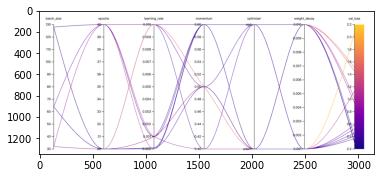

In [120]:
import matplotlib.image as im
import matplotlib.pyplot as plt
os.chdir("/content/gdrive/MyDrive/acse4/")
imgpath_1 = './random_pick.png'

img = im.imread(imgpath_1)
plt.imshow(img)


### Random

In [78]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [30, 40]
        },
        'momentum': {
            'values': [0.4, 0.5, 0.6]
        },
        'weight_decay':{
            'values':[1e-2, 1e-3]
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'learning_rate': {
            'values': [1e-2, 1e-3, 1e-4,1e-5]
        },
        'optimizer': {
            'values': ['sgd', 'adam']
        },
    }
}

In [79]:
sweep_id = wandb.sweep(sweep_config, project="my-project-3")

Create sweep with ID: gdxgbzfj
Sweep URL: https://wandb.ai/ewan/my-project-3/sweeps/gdxgbzfj


In [80]:
wandb.agent(sweep_id, train_RESNET18_wandb)

wandb: Agent Starting Run: ho66j5dz with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


train_loss,0.00921
_runtime,122
_timestamp,1621592836
_step,119
train_acc,1.0
val_loss,0.36622
val_acc,0.92079


train_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▆▇▇██████████████████████████
val_loss,█▄▃▃▅▄▄▃▂▂▂▁▁▂▂▁▁▁▁▂▂▂▅▄▂▂▂▅▃▂
val_acc,▁▆▇▆▃▅▆▇▇▇▇▇▇▇▇▇████▇█▆▆▇▇▆▆▇█


wandb: Agent Starting Run: 52d0tcty with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.00463
_runtime,122
_timestamp,1621592965
_step,119
train_acc,1.0
val_loss,0.31198
val_acc,0.93069


train_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▆▇▇████████████████▇▇▇▇██████
val_loss,▄▃▂▂▂▂▁▁▁▁▂▃▁▁█▂▂▂▂▂▇▃▂▂▁▂▂▂▁▁
val_acc,▁▅▅▆▆▆▆█▆▆▆▆▆▆▁▆▇▆▆▇▄▅▄▆▇▆▆███


wandb: Agent Starting Run: sjv9jq6b with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.40313
_runtime,130
_timestamp,1621593106
_step,119
train_acc,0.85589
val_loss,1.01585
val_acc,0.66337


train_loss,█▃▃▃▄▃▃▃▂▂▂▃▃▄▃▂▂▂▃▃▂▂▂▂▁▃▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▅▆▅▅▅▅▆▆▇▆▅▆▅▅▇▇▇▅▆▆▇▆▇█▅▇███
val_loss,▂▁▁▁▅▃▁▇▁▄█▃▄▃▁▄█▅▂▁▂▁▃▂▅▅▂▂▂▂
val_acc,▇█▇▆▅▂▇▂▆▅▁▆▅▄▆▃▂▁▆▇▆▇▅▄▁▂▆▇▃▆


wandb: Agent Starting Run: lcla79tq with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,1.11254
_runtime,122
_timestamp,1621593236
_step,119
train_acc,0.51815
val_loss,1.50643
val_acc,0.32673


train_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▂▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▁▃▄▆▇▇▆▆▇▅▇▆▆▆▆▆▇▇▇▆▆▇▆▄▇█▇█▄
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▂▇▇▇▇▇▇▇▇▇▇▇▇▇▄▅▄▇▇▁▅▇▇▆█▂▄▄▄


wandb: Agent Starting Run: avbuqy2h with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


train_loss,0.15339
_runtime,129
_timestamp,1621593372
_step,119
train_acc,0.9527
val_loss,2.06849
val_acc,0.56436


train_loss,█▅▄▃▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▃▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████▆▇
val_loss,▃▁▂▁▁▄▂▂▂▁▃▁▃▁█▄▃▅▁▁▃▁▂▁▁▂▂▁▂▄
val_acc,▆▆▆▇█▃▇▆▆▇▃▇▅▇▁▂▄▁▇█▄█▆▇▇▆▅▇▇▄


wandb: Agent Starting Run: 65ewcfba with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


train_loss,0.06542
_runtime,128
_timestamp,1621593508
_step,119
train_acc,0.9945
val_loss,0.39492
val_acc,0.87129


train_loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████████████
val_loss,█▆▅▄▄▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁
val_acc,▁▃▃▄▅▅▆▅▆▇▆▇▆▇█▇▇▇▇▇▇▇▆█▇▇▆▇▇▇


wandb: Agent Starting Run: 6jkxm16c with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,0.00257
_runtime,127
_timestamp,1621593643
_step,119
train_acc,1.0
val_loss,0.45707
val_acc,0.88119


train_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▆▇▇█▇███████████████████████
val_loss,▆▄█▂▁▄▂▇▁▂▃▃█▂▃▂▃▃▃▅▃▅▅▄▂▃▃▃▃▃
val_acc,▃▅▁▇▇▆▆▃▇█▆█▅▇▇████▆▆▆▇█▇█▇██▇


wandb: Agent Starting Run: qnofaxmz with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,0.22039
_runtime,159
_timestamp,1621593810
_step,159
train_acc,0.94939
val_loss,0.4052
val_acc,0.85149


train_loss,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_acc,▁▂▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_loss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁
val_acc,▁▂▃▃▃▄▅▅▆▅▆▆▆▆▆▇▆▆▆▆▇▇▇▇▇██████▇█████▇▆▇


wandb: Agent Starting Run: q8fv03wq with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.45936
_runtime,130
_timestamp,1621593949
_step,119
train_acc,0.83828
val_loss,1.44901
val_acc,0.63366


train_loss,█▄▄▄▅▄▄▄▅▅▄▃▄▄▃▂▂▂▃▃▂▂▂▂▁▃▁▂▁▃
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▅▄▄▃▅▄▅▃▃▅▅▅▅▅▆▆▇▆▆▇▆▇▇█▆█▇█▆
val_loss,▂▂▁▃▃▃▁▂█▁▃▄▁▂▁▂▃▆▂▄▄▃▂▁█▁▄▂▃▂
val_acc,▇▅▇▄▃▄█▇▁▇▂▆▇▄▇▅▅▃▄▃▃▆▆█▂█▃▇▄▆


wandb: Agent Starting Run: j7oii5ws with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,0.00487
_runtime,163
_timestamp,1621594120
_step,159
train_acc,1.0
val_loss,0.58693
val_acc,0.85149


train_loss,█▅▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_acc,▁▅▆▇▇█▇███████████████▇█████████████████
val_loss,▄▂▆▁▃▇▂▂▁▁▁▂▂▁▂▁▁▁▁▂▁█▃▂▂▂▁▁▁▁▄▂▂▃▃▁▂▂▃▃
val_acc,▄▆▂▇▆▁▆▆▇██▇▆▇▇▇▇▇▇▇█▁▅▇█▇▇█▇█▅█▇▇▅▇█▇▆▇


wandb: Agent Starting Run: ti70eudo with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.0433
_runtime,123
_timestamp,1621594249
_step,119
train_acc,0.9967
val_loss,0.29857
val_acc,0.89109


train_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▅▅▆▆▆▇▇▇▇▇▇█████████████████
val_loss,█▆▅▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▃▅▆▆▇▇▇█████████████████████


wandb: Agent Starting Run: sg9wpg8k with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.26791
_runtime,173
_timestamp,1621594428
_step,159
train_acc,0.90319
val_loss,0.93621
val_acc,0.69307


train_loss,█▄▄▅▄▄▄▄▄▅▄▄▄▃▃▃▃▃▄▃▃▃▄▃▃▃▃▄▃▂▃▂▂▃▂▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_acc,▁▅▅▄▄▅▅▅▅▄▄▄▅▅▅▆▅▅▅▅▅▆▅▆▆▇▆▅▅▇▆▇▇▆▇▆▇███
val_loss,▁▂▂▄█▃▃▂▁▂▅▂▅▁▁▃▆▂▃▃▃▂▂▂▂▁▄▆▅▂▁▂▄▁▃▂▃▁▁▂
val_acc,█▅▇▆▁▃▆▆▇▆▁▄▃▇▇▇▃▆▄▆▂▇▇▅▆▇▅▁▅▇█▇▃▇▅▇▄██▇


wandb: Agent Starting Run: 3u2yl1ef with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,1.13489
_runtime,160
_timestamp,1621594594
_step,159
train_acc,0.50605
val_loss,1.1332
val_acc,0.49505


train_loss,▇█▇▇▇▆▇▆▆▆▆▆▅▅▆▄▄▄▄▃▄▃▃▄▃▃▃▂▂▂▂▁▂▂▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_acc,▂▁▂▁▂▁▁▂▂▃▃▃▃▄▂▅▄▄▅▆▆▅█▅▅▅▅█▇▆▅█▇▆██▇▆█▆
val_loss,▆▇███▇▇▆▆▅▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁
val_acc,█▆▄▂▁▁▂▁▃▆▆▆▅▅▅▅▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▅▅▅▅▆▆▆▅▅


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cgshiftg with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,0.01452
_runtime,121
_timestamp,1621594731
_step,119
train_acc,1.0
val_loss,0.45996
val_acc,0.87129


train_loss,█▆▅▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▅▆▆▇▇▇▇█▇▇██████████▇███████
val_loss,▇▆▄▂▂▃▅▂▂▁▄▂▂▃▁▁▂▆▁▂▂█▄▁▂▁▅▆▂▂
val_acc,▁▂▃▇▆▅▁▆▇▇▅▆▇▆▇▇▇▄▆▇▆▃▆▇▇█▅▅▇▇


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gg0ijzkc with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.92191
_runtime,161
_timestamp,1621594911
_step,159
train_acc,0.60506
val_loss,1.19238
val_acc,0.57426


train_loss,█▃▂▃▃▃▂▂▃▂▂▂▂▃▂▂▁▂▂▁▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_acc,▁▁▄▅▃▃▇▄▅▆▆▇▇▃▆▆▇▇▆▇▆▆▆▆▇▇▇▇▇▃▆▇▇▇▇▇█▆█▇
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▃▁▄▆▆▄▆▆▆▆▆▇▇▇▄▆▆▆▆▆▆▆▆█▆▃█▃▇▃▃▆▃▆▆██▆▆▇


wandb: Agent Starting Run: giy5k32q with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


wandb: Ctrl + C detected. Stopping sweep.


---------

### Grid search

In [106]:
sweep_config_2 = {
    'method': 'grid', #grid, random
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [30, 40]
        },
        'momentum': {
            'values': [0.4, 0.5, 0.6]
        },
        'weight_decay':{
            'values':[1e-2, 1e-3]
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'learning_rate': {
            'values': [1e-2, 1e-3, 1e-4,1e-5]
        },
        'optimizer': {
            'values': ['sgd', 'adam']
        },
    }
}

sweep_id_2 = wandb.sweep(sweep_config_2, project="my-project-4")
wandb.agent(sweep_id_2, train_RESNET18_wandb)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: c17mwucj
Sweep URL: https://wandb.ai/ewan/my-project-4/sweeps/c17mwucj


wandb: Agent Starting Run: nkuw2g8f with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


train_loss,0.00558
_runtime,128
_timestamp,1621596907
_step,119
train_acc,1.0
val_loss,0.39978
val_acc,0.90099


train_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▅▆▆▇█▇███████████████▇███████
val_loss,▆▃▅▃▁█▂▃▂▁▂▂▃▂▃▂▂▂▂▃▁█▂▃▁▂▁▂▂▂
val_acc,▃▄▃▅▅▁▆▆▅▆▇▇▆▇▆▇▇▇▇▇█▄▅█▇▇▇█▇▇


wandb: Agent Starting Run: c2ql0jn5 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,0.00298
_runtime,128
_timestamp,1621597041
_step,119
train_acc,1.0
val_loss,0.43251
val_acc,0.89109


train_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▅▆▆▇█▇███████████████▇███████
val_loss,▅▂█▆▂▆▃▃▂▁▂▂▆▂▂▂▂▂▃▄▅▇▂▃▃▂▂▄▃▃
val_acc,▃▅▁▅▆▃▅▆▅▇▇█▆▇▇▇▇▇▇▇▆▅▇█▇▆▆▆▇▇


wandb: Agent Starting Run: sorqin0c with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,1.02051
_runtime,132
_timestamp,1621597179
_step,119
train_acc,0.59626
val_loss,1.27954
val_acc,0.50495


train_loss,█▃▂▂▂▂▁▂▂▂▁▂▂▁▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▆▆▆▇█▇▇▇▇▇▇▇▆█▇██▆██▇███████
val_loss,█▂▆▂▁▁▂▁▄▁▁▂▁▁▁▁▄▁▁▂▁▁▁▁▁▁▁▁▃▂
val_acc,▅▃▁▆▆▆▆▇▆▆▆▆▆▆▆▆▃▆▆▆█▆▆▆▆▆▇█▅▆


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jw6mn623 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


train_loss,0.83047
_runtime,133
_timestamp,1621597328
_step,119
train_acc,0.64796
val_loss,1.07169
val_acc,0.60396


train_loss,█▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▂▃▅▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇█▇██████
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▅▅▅▁▅▆▇▆▅▇▁▂▅█▇▆▇▄▃█▁▅▆▂▇▅▇█▂▇


wandb: Agent Starting Run: rm2taz5z with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


train_loss,0.00374
_runtime,130
_timestamp,1621597464
_step,119
train_acc,1.0
val_loss,0.40108
val_acc,0.87129


train_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▅▆▆▇█████████████████▇███████
val_loss,▄▅▄▂▂▂▃▂▂▁▂▂▃▂▂▂▂▂▂▄▃█▄▁▂▁▁▂▂▂
val_acc,▄▁▂▆▆▅▅▇▄█▅▅▇▇▇▇█▇▇▇▅▃▆█▅▆█▇▇▆


wandb: Agent Starting Run: u4pod4zb with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,0.00265
_runtime,130
_timestamp,1621597605
_step,119
train_acc,1.0
val_loss,0.5649
val_acc,0.89109


train_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▅▆▆▇█▇███████████████████████
val_loss,▃▂█▁▂▃▃▂▄▁▂▂▃▂▃▂▂▃▂▃▂▃▂▃▄▃▃▃▃▃
val_acc,▅▅▁▇▇▅▅▇▅█▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇▇▇▇▇


wandb: Agent Starting Run: k7t1xf8j with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.98974
_runtime,132
_timestamp,1621597743
_step,119
train_acc,0.61056
val_loss,1.60164
val_acc,0.26733


train_loss,█▄▃▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▅▆▇▆▆▇▇▇▇▇▇▇▇▇██▇▇▇▇████▇███
val_loss,▄▁▁▁█▁▁▂▂▁▂▂▂▁▁▂▂▂▂▃▇▁▃▁▂▁▃▃▁▃
val_acc,▆▆█▆▃▆▇▆▆█▂▇▆▇▇▆▃▇▇▆▁█▆██▆▆▂█▁


wandb: Agent Starting Run: z382n1aq with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


train_loss,0.75556
_runtime,133
_timestamp,1621597884
_step,119
train_acc,0.70187
val_loss,0.98579
val_acc,0.59406


train_loss,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▅▅▆▆▆▆▆▆▆▆▆▇▆▆▇▇▆▇▇▇▇▇▇██▇██
val_loss,█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▄▅▆▆▆▁▃▄▄▇▄▅▄▆▄▄▅▂▄▃▂▆▅▆▆▆█▆▅▆


wandb: Agent Starting Run: b7xjgmaw with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


train_loss,0.00359
_runtime,131
_timestamp,1621598022
_step,119
train_acc,1.0
val_loss,0.38225
val_acc,0.87129


train_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▅▆▆▇█▇███████████████▇███████
val_loss,▂▂█▃▂▂▂▂▁▁▁▁▄▁▁▂▁▁▁▁▁▃▃▁▁▁▁▁▁▁
val_acc,▇▆▁▆▇▇▇▇▇██▇▆▇█▇▇███▇▇▇██▇███▇


wandb: Agent Starting Run: qep440wg with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,0.00232
_runtime,131
_timestamp,1621598159
_step,119
train_acc,1.0
val_loss,0.3734
val_acc,0.88119


train_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▆▆▇█████████████████████████
val_loss,▄▂█▂▂▄▂▂▁▁▂▂▂▂▂▁▁▂▂▄▄▅▃▂▁▂▂▂▂▁
val_acc,▅▅▁▆▆▃▅▇▇▇▇▆▇▇▇▇▇▇█▄█▆▅█▇▆▇▇▇▇


wandb: Agent Starting Run: 7yb5cg21 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.96846
_runtime,133
_timestamp,1621598301
_step,119
train_acc,0.60946
val_loss,1.29186
val_acc,0.50495


train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▄▅▃▅▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇██▇██▇█
val_loss,▁▁▁█▁▁▁▁▂▁▂▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁
val_acc,▁▆▆▆▆▆▃▅▁▁▁█▆▆▆▇▃▂▇▆▁▂▇▇▇▂▄▇▂▆


wandb: Agent Starting Run: jkx6753q with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


train_loss,0.85662
_runtime,133
_timestamp,1621598440
_step,119
train_acc,0.64356
val_loss,1.41392
val_acc,0.51485


train_loss,█▄▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▅▅▆▆▇▆▆▇▇▇▇▇▇▆▇▆▇▆▇▇▇████▇██
val_loss,▄▂▂▁▁▂▁▂▂▁▁▄▁▁▁▂▂█▁▂▁▂▂▂▁▁▃▁▂▂
val_acc,▄▅▅▅▇▅▇▅▆▅▅▁▇▇▇▅▅▁▆▄▇▆▅▅▆▇▁█▄▅


wandb: Agent Starting Run: kqd2a408 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


train_loss,0.12318
_runtime,129
_timestamp,1621598575
_step,119
train_acc,0.978
val_loss,0.37516
val_acc,0.89109


train_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▄▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇███████████
val_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁
val_acc,▁▃▃▄▆▅▆▆▆▇▇▇▇▇██▇▇▇███▇▇▇█▇▇▇█


wandb: Agent Starting Run: 0kkkqztp with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,0.11378
_runtime,129
_timestamp,1621598712
_step,119
train_acc,0.978
val_loss,0.4161
val_acc,0.85149


train_loss,█▇▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
val_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁
val_acc,▁▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██▇██▇▇█▇▇


wandb: Agent Starting Run: mvesqlqw with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.52644
_runtime,132
_timestamp,1621598853
_step,119
train_acc,0.81738
val_loss,1.16377
val_acc,0.63366


train_loss,█▃▃▃▃▃▃▃▂▃▂▃▃▁▃▁▁▃▄▃▅▃▃▂▂▂▂▁▂▃
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▅▆▆▆▅▅▆▆▅▇▆▅▇▆█▇▅▅▆▄▅▆▇▇▆▇█▆▆
val_loss,▁▁▁▁▅▂▁▂▁▁▅▁▁▁▁▂▁▆▁▁▇▁▁▁▁▇▃▃█▁
val_acc,█▇▇▆▁▄▇▃▇▇▁█▇▇▆▅▅▅▆▆▁▇▇▆▇▁▂▄▁▆


wandb: Agent Starting Run: elmuh2b6 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


train_loss,0.17591
_runtime,132
_timestamp,1621598991
_step,119
train_acc,0.94279
val_loss,0.73711
val_acc,0.74257


train_loss,█▅▄▄▃▃▃▃▃▂▂▃▃▂▂▂▁▁▂▁▂▁▂▁▂▁▁▁▂▂
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▅▅▆▆▆▆▆▇▇▆▆▇▇▇██▇█▇▇▇█▇███▇▇
val_loss,▂▁▁▂█▁▂▃▁▁▂▂▂▁▂▂▁▂▁▁▁▁▂▂▁▂▁▂▃▁
val_acc,▆▆▇▇▁▇▇▅█▇▆▇▇▇▇▄█▇▇█▇▇▆▅█▇█▆▅▇


wandb: Agent Starting Run: 0xf64j68 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


train_loss,0.09215
_runtime,128
_timestamp,1621599126
_step,119
train_acc,0.9868
val_loss,0.3821
val_acc,0.87129


train_loss,█▇▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇██████████
val_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
val_acc,▁▃▄▅▅▆▆▆▇▇▇██▇█▇▇█▇█▇█▇███▇███


wandb: Agent Starting Run: lr1eblyf with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,0.09174
_runtime,129
_timestamp,1621599262
_step,119
train_acc,0.9824
val_loss,0.39445
val_acc,0.86139


train_loss,█▇▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
val_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁
val_acc,▁▂▃▄▅▄▆▅▅▇▆▇▇██▇▇▇█▇█▇▇█▇▇▅█▇▇


wandb: Agent Starting Run: adzcka1b with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.31865
_runtime,131
_timestamp,1621599400
_step,119
train_acc,0.89219
val_loss,0.72444
val_acc,0.69307


train_loss,█▄▃▄▄▄▄▄▄▃▃▃▄▄▄▃▂▂▃▃▃▂▂▃▂▂▂▂▂▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▅▅▅▅▅▅▄▄▅▅▆▄▅▅▆▆▆▅▆▆▇▇▆▇▇▇▇▇█
val_loss,▃▂▁▁▂█▃▂▃▄▂▂▁▃▂▁▆▂▁▄▃▂▃▃▄▂▆▁▂▁
val_acc,▇▅▆█▂▃▆▄▇▃▅▅▇▄▆█▁▆▇▂▄▆▄▅▃▆▁▇▅▆


wandb: Agent Starting Run: ulrhu2ni with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


train_loss,0.15122
_runtime,132
_timestamp,1621599539
_step,119
train_acc,0.9571
val_loss,1.1963
val_acc,0.64356


train_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▅▅▅▅▅▆▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇████▇█
val_loss,▃▂▂▂▁▃▁▃▄▁▃▂▁▂▂▂▁▂▁▁▂▂▂█▂▂▂▁▂▂
val_acc,▅▅▆▅▇▅▆▄▂▇▃▆▇▅▅▅█▅▆▆▅▄▅▁▆▆▆▇▄▄


wandb: Agent Starting Run: rsq56gw0 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


train_loss,0.06173
_runtime,129
_timestamp,1621599676
_step,119
train_acc,0.9934
val_loss,0.33631
val_acc,0.88119


train_loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████████████
val_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁▃▂▁▁▁▁▂▁▁▁▁▁▁▂▁
val_acc,▁▃▃▄▄▅▆▆▆▇▆▆▆██▆███▇█▇▇█▇█▇█▇▇


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u8i5itt5 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,0.06144
_runtime,129
_timestamp,1621599824
_step,119
train_acc,0.9934
val_loss,0.33922
val_acc,0.91089


train_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇██████████████
val_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▄▅▅▅▅▇▆▇▆▇▆▇▆▇▇▇▇█▇▇▇▇█▆█▇█


wandb: Agent Starting Run: k1x4x4gm with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.3036
_runtime,131
_timestamp,1621599962
_step,119
train_acc,0.89659
val_loss,1.90835
val_acc,0.40594


train_loss,█▅▄▃▄▄▄▄▅▃▃▃▅▃▄▂▃▃▃▃▃▂▂▂▂▃▂▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▅▆▅▅▅▅▂▅▅▆▄▆▅▇▆▆▅▆▅▆▇▇▇▆▇▆▆█
val_loss,▃▁▁▂▃▆▁▂▃▁▃▂▄▃▂▄▂▃▄▃▂▄▁▁█▃▄▂▂▄
val_acc,▇▇▇▆▅▂█▆▄▇▆▆▅▄▆▆▆▆▃▆▅▅▇█▁▄▅▇▅▃


wandb: Agent Starting Run: 9zr7v9dx with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


train_loss,0.10249
_runtime,129
_timestamp,1621600098
_step,119
train_acc,0.9692
val_loss,0.76023
val_acc,0.82178


train_loss,█▅▄▄▃▃▃▃▃▂▂▂▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▄▅▆▆▆▆▆▇▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇███▇█
val_loss,▂▂▁▂▄▁▁▂▁▁▁▁▂█▁▁▅▂▁▂▂▁▅▂▁▁▁▁▂▂
val_acc,▇▅▇▆▁██▆▇█▇█▇▂▇▇▃▆▇▆▇█▂▆███▇▇▇


wandb: Agent Starting Run: 1mngw7xl with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


train_loss,0.69605
_runtime,126
_timestamp,1621600232
_step,119
train_acc,0.75798
val_loss,0.76729
val_acc,0.73267


train_loss,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▁▂▃▃▃▄▄▅▅▅▅▅▆▅▆▆▆▇▇▇▇▇▇▇▇████
val_loss,█▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
val_acc,▁▂▂▄▄▄▄▅▅▅▆▅▅▆▆▇▇▇▆▇▆▇█▇▇▇█▇▇█


wandb: Agent Starting Run: w6d0tjzs with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,0.70729
_runtime,125
_timestamp,1621600366
_step,119
train_acc,0.76018
val_loss,0.75823
val_acc,0.72277


train_loss,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▁▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███
val_loss,█▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁
val_acc,▁▂▂▂▄▃▄▄▅▆▆▆▆▇▇▆▇▇▇▇▆▇▇▇▇▇█▇▇█


wandb: Agent Starting Run: k6sbl664 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.01645
_runtime,128
_timestamp,1621600502
_step,119
train_acc,0.9956
val_loss,0.45241
val_acc,0.83168


train_loss,█▄▂▂▁▁▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▂▃▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▆▇▇██████▇▇▇█████████▆▇██████
val_loss,▂▂▁▁▁▁▂▂▂▂█▂▂▇▂▂▃▃▁▂▃▂▅▁▁▂▂▃▂▂
val_acc,▆▇████▇██▇▁▇▇▂▇▇▇▇▇███▅█▇▇▇▇▇▆


wandb: Agent Starting Run: hc4olrk3 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


train_loss,0.01574
_runtime,128
_timestamp,1621600639
_step,119
train_acc,0.9956
val_loss,0.41504
val_acc,0.89109


train_loss,█▄▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▅▇▇██▇███████████████▇▇██████
val_loss,▆▃▁▂▂▂▃▃▁▂▅▅▅▃▄▄▄▄▄▄▅▂█▅▂▅▅▄▄▄
val_acc,▁▄▆▆▆▆▆▆▆▇▆▃▃▆▇▄▆▆▆▅▆▅▃▇█▆▇▇▇▆


wandb: Agent Starting Run: 58qjiafu with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


train_loss,0.65089
_runtime,126
_timestamp,1621600776
_step,119
train_acc,0.77228
val_loss,0.72831
val_acc,0.76238


train_loss,█▇▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▂▂▃▃▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█████
val_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
val_acc,▁▃▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇█


wandb: Agent Starting Run: k61fb3dl with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,0.66145
_runtime,126
_timestamp,1621600910
_step,119
train_acc,0.77338
val_loss,0.71194
val_acc,0.74257


train_loss,█▇▇▆▆▆▅▅▅▄▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▂▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▆▇▇▇█▇████
val_loss,█▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
val_acc,▁▂▃▃▄▄▆▅▅▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▆▇▇▇██


wandb: Agent Starting Run: u4tpg1hi with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.02476
_runtime,129
_timestamp,1621601046
_step,119
train_acc,0.9912
val_loss,0.66816
val_acc,0.91089


train_loss,█▃▂▂▁▁▂▁▁▁▁▁▁▁▁▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▆▇▇██▇████▇███▇▇▇▇▇▇█▇███████
val_loss,▄▂▁▂▂▂▂▂▂▃▆▆▂▂▆█▄▄▄▅▅▄▅▄▅▄█▆▇▇
val_acc,▁▆▇█▇▇▅█▇▄▄▁▄▆▃▂▆▃▇▄▅▅▆▅▅▆▂▅▃▇


wandb: Agent Starting Run: s6dapapd with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


train_loss,0.03704
_runtime,130
_timestamp,1621601185
_step,119
train_acc,0.9912
val_loss,0.44863
val_acc,0.86139


train_loss,█▄▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▆▇▇██▇███████████████▇▇██▇▇▇█
val_loss,▇▄▁▁▄▇▃▃▂▃▄▄▄▆▇▆▇▅▅▄▂▂▆▇▄▅██▁▅
val_acc,▁▃▅▇▆▄▇▇▇▆▆▆▇▆█▆▇▇█▇▅▆▆▅▃▆▁▄▅▅


wandb: Agent Starting Run: lzx3w8n0 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


train_loss,0.58855
_runtime,126
_timestamp,1621601320
_step,119
train_acc,0.80308
val_loss,0.6781
val_acc,0.74257


train_loss,█▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▂▂▃▃▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇████
val_loss,█▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
val_acc,▁▂▃▄▅▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇█▇▇██▇█▇


wandb: Agent Starting Run: 1iy43bxy with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,0.59873
_runtime,126
_timestamp,1621601454
_step,119
train_acc,0.80198
val_loss,0.68008
val_acc,0.76238


train_loss,█▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▂▂▂▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
val_loss,█▇▇▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▁▂▃▄▄▄▅▆▆▆▆▇▇▇▇▇▇█████▇▇▇██▇██


wandb: Agent Starting Run: pz49e1vw with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.02581
_runtime,132
_timestamp,1621601593
_step,119
train_acc,0.9934
val_loss,0.60293
val_acc,0.88119


train_loss,█▃▂▂▂▁▂▁▂▁▁▂▂▁▂▁▁▁▁▁▂▁▂▂▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▆▇▇██▇█▇██▇▇█▇███████▇▇▇█████
val_loss,▂▁▁▁▁▁▁▂▂▁▅▄▃▃▂▃▂▃▁▃▃█▄▅▂▂▃▃▃▃
val_acc,▅█▆▇▇▇██▇█▃▅▆▆▆▇█▇█▆█▁▄▆▇▇▇▇█▇


wandb: Agent Starting Run: 8rdl6s96 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


train_loss,0.00869
_runtime,129
_timestamp,1621601730
_step,119
train_acc,0.9978
val_loss,0.45716
val_acc,0.90099


train_loss,█▄▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▆▇▇██▇███████▇███████▇▇▇▇████
val_loss,▃▁▁▂▂▂▂▂▁▁▃▂▂▄▁▂▂▃▃▂▄▂▂▆▂█▂▃▁▃
val_acc,▃▇▆█▇█▇█▇█▆▇█▃▇▅█▆█▇▇▇▇▅▇▁▇▇▇█


wandb: Agent Starting Run: usavb45j with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


train_loss,1.08937
_runtime,126
_timestamp,1621601869
_step,119
train_acc,0.55006
val_loss,1.09411
val_acc,0.49505


train_loss,██▇▇▇▇▇▆▆▅▅▅▄▄▅▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▂▁▂▃▂▁▃▃▂▄▄▃▄▄▄▅▅▅▆▆▅▅▇▆▆▆▇▇▇█
val_loss,██▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
val_acc,▃▁▆▄▆▅▅▇▆▇▇▅▆▆▆▆▆▇▇▆▆▇▆▆▇▆▇█▆▆


wandb: Agent Starting Run: 1q1ena0e with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,1.08965
_runtime,129
_timestamp,1621602007
_step,119
train_acc,0.55556
val_loss,1.09386
val_acc,0.51485


train_loss,██▇▇▇▇▇▆▆▅▅▅▄▄▅▄▄▃▃▃▃▃▃▂▂▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▁▂▂▂▁▂▃▂▄▄▃▄▄▄▄▅▅▅▆▅▅▇▆▅▅▇▇▇█
val_loss,██▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
val_acc,▂▁▅▂▅▃▅▇▆▇▇▅▆▆▆▇▆▇▇▆▆▇▆▇▇▆▆█▇▇


wandb: Agent Starting Run: 9ay4phxu with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.02323
_runtime,131
_timestamp,1621602146
_step,119
train_acc,1.0
val_loss,0.28931
val_acc,0.91089


train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▅▆▆▇▇▇▇▇▇███████████████████
val_loss,█▆▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▇▇▇▇█▇▇▇▇█████████▇███████


wandb: Agent Starting Run: xupzcwxc with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


train_loss,0.02072
_runtime,131
_timestamp,1621602285
_step,119
train_acc,1.0
val_loss,0.29001
val_acc,0.91089


train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▅▆▆▇▇▇▇▇▇███████████████████
val_loss,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▇▇▇▇██▇███████████████████


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0sc27gix with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


train_loss,1.07314
_runtime,130
_timestamp,1621602434
_step,119
train_acc,0.55996
val_loss,1.07936
val_acc,0.52475


train_loss,██▇▇▇▇▆▆▆▅▅▅▄▄▅▄▄▃▃▃▃▃▃▂▂▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▂▁▃▂▂▂▃▃▂▄▄▃▄▄▄▅▅▅▆▆▅▆▇▆▆▆▇▇▇█
val_loss,██▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
val_acc,▂▁▅▃▅▄▅▆▆▆▅▅▅▅▆▅▅▅▆▅▅▆▆▆▇▅▇█▆▇


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: za883d18 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,1.07288
_runtime,131
_timestamp,1621602583
_step,119
train_acc,0.55996
val_loss,1.07981
val_acc,0.52475


train_loss,██▇▇▇▇▆▆▆▅▅▅▄▄▅▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▂▁▂▂▂▂▃▃▂▄▄▃▅▄▄▅▅▅▆▆▅▆▇▆▆▆▇▇▇█
val_loss,██▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
val_acc,▃▁▅▃▅▄▄▆▆▆▆▅▅▅▆▆▅▅▆▆▆▇▆▆█▆▇▇▆▇


wandb: Agent Starting Run: 3x4p5y7e with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.02321
_runtime,132
_timestamp,1621602723
_step,119
train_acc,1.0
val_loss,0.2921
val_acc,0.91089


train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▅▆▆▇▇▇▇▇▇███████████████████
val_loss,█▆▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▇▇▇▇██▇▇██████████▇███████


wandb: Agent Starting Run: 5li6w0py with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


train_loss,0.02076
_runtime,133
_timestamp,1621602864
_step,119
train_acc,1.0
val_loss,0.29007
val_acc,0.92079


train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▅▆▆▇▇▇▇▇▇███████████████████
val_loss,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▇▇▇▇█▇▇███████████████████


wandb: Agent Starting Run: 4womeg3r with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


train_loss,1.04946
_runtime,130
_timestamp,1621603002
_step,119
train_acc,0.57756
val_loss,1.0619
val_acc,0.54455


train_loss,██▇▇▇▆▆▆▆▅▅▅▄▄▅▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▁▂▂▁▂▃▃▂▃▄▃▄▄▄▄▅▅▅▅▆▆▇▆▆▅▆▇▇█
val_loss,██▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▂▁▅▂▅▃▄▆▆▆▅▅▆▅▆▆▅▆█▆▅▆▆▇▇▇█▇▇█


wandb: Agent Starting Run: qil74980 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.6
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


train_loss,1.04909
_runtime,129
_timestamp,1621603139
_step,119
train_acc,0.57976
val_loss,1.06252
val_acc,0.54455


train_loss,██▇▇▇▆▆▆▆▅▅▅▄▄▅▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▂▁▂▂▂▂▃▃▂▃▄▃▄▄▄▄▄▅▅▅▅▅▆▆▆▅▆▇▇█
val_loss,██▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
val_acc,▂▁▄▃▄▄▄▅▆▅▅▄▄▅▅▅▅▆█▅▅▆▅▆▇▆▇▆▆▇


wandb: Agent Starting Run: hkdvk34x with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


train_loss,0.02319
_runtime,131
_timestamp,1621603281
_step,119
train_acc,1.0
val_loss,0.28986
val_acc,0.91089


train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▅▆▆▇▇▇▇▇▇███████████████████
val_loss,█▆▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▇▇▇▇█▇▇▇▇█████████▇███████


wandb: Agent Starting Run: gzoyx10o with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	momentum: 0.6
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


train_loss,0.02079
_runtime,131
_timestamp,1621603423
_step,119
train_acc,1.0
val_loss,0.28981
val_acc,0.92079


train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▅▆▆▇▇▇▇▇▇███████████████████
val_loss,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▇▇▇▇██████████████████████


wandb: Agent Starting Run: o6fspoty with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


wandb: Ctrl + C detected. Stopping sweep.


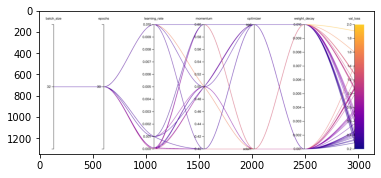

In [121]:
imgpath_2 = './grid.png'

img = im.imread(imgpath_2)
plt.imshow(img)